In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gabpa510/miniconda3/envs/graphsage/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gabpa510/miniconda3/en

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
import h5py
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree
from tensorflow.keras.utils import to_categorical

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.layer.graphsage import AttentionalAggregator
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Load Data

In [6]:
import numpy as np
import h5py
from collections import OrderedDict

pixel_per_um = 15.3846 # from BioRxiv paper
um_per_pixel = 1.0 / pixel_per_um
f = h5py.File("../data/osmFISH_Codeluppi_et_al/mRNA_coords_raw_counting.hdf5", 'r')
keys = list(f.keys())

pos_dic = OrderedDict()
genes = []

# Exclude bad quality data, according to the supplementary material of osmFISH paper
blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

barcodes_df = pd.DataFrame({'Gene':[], 'Centroid_X':[], 'Centroid_Y':[]})
for k in keys:
    if k in blacklists:
        continue
    gene = k.split("_")[0]
    
    # Correct wrong gene labels
    if gene == 'Tmem6':
        gene = 'Tmem2'
    elif gene == 'Kcnip':
        gene = 'Kcnip2'
    
    points = np.array(f[k]) * um_per_pixel
    if gene in pos_dic:
        pos_dic[gene] = np.vstack((pos_dic[gene], points))
    else:
        pos_dic[gene] = points
        genes.append(gene)
    
    barcodes_df = barcodes_df.append(pd.DataFrame({'Gene':[gene]*points.shape[0], 'Centroid_X':points[:,0], 'Centroid_Y':points[:,1]}),ignore_index=True)

# Gene panel taglist    
tagList_df = pd.DataFrame(sorted(genes),columns=['Gene'])
# Spot dataframe from Codeluppi et al.
barcodes_df.reset_index(drop=True, inplace=True)

(-2164.837900499997,
 96.21083187292864,
 -3526.0465378188887,
 161.64317341552442)

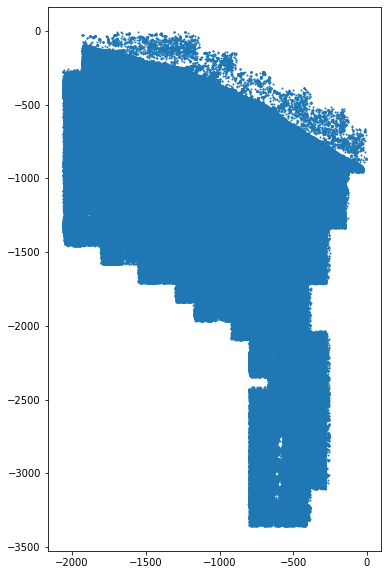

In [7]:
import matplotlib.pyplot as plt

X = -barcodes_df.Centroid_X
Y = -barcodes_df.Centroid_Y

plt.figure(figsize=(10,10))
plt.scatter(X,Y,s=1)
plt.axis('scaled')

## Build Graph

In [8]:
# Auxiliary function to compute d_max
def plotNeighbor(barcodes_df):
    barcodes_df.reset_index(drop=True, inplace=True)
    
    kdT = KDTree(np.array([barcodes_df.Centroid_X.values,barcodes_df.Centroid_Y.values]).T)
    d,i = kdT.query(np.array([barcodes_df.Centroid_X.values,barcodes_df.Centroid_Y.values]).T,k=2)
    plt.hist(d[:,1],bins=200);
    plt.axvline(x=np.percentile(d[:,1],97),c='r')
    print(np.percentile(d[:,1],97))
    d_th = np.percentile(d[:,1],97)
    return d_th

1.6912512293147743


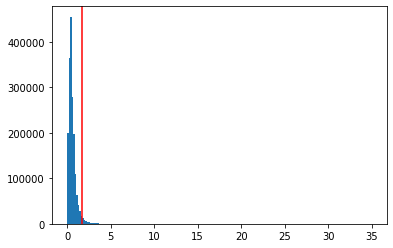

In [9]:
# Compute d_max for generating spatial graph
d_th = plotNeighbor(barcodes_df)

In [10]:
# Auxiliary function to build spatial gene expression graph
def buildGraph(barcodes_df, d_th, tagList_df):
    G = nx.Graph()
    features =[] 
    barcodes_df.reset_index(drop=True, inplace=True)
    
    gene_list = tagList_df.Gene.values
    # Generate node categorical features
    one_hot_encoding = dict(zip(tagList_df.Gene.unique(),to_categorical(np.arange(tagList_df.Gene.unique().shape[0]),num_classes=tagList_df.Gene.unique().shape[0]).tolist()))
    barcodes_df["feature"] = barcodes_df['Gene'].map(one_hot_encoding).tolist()
    features.append(np.vstack(barcodes_df.feature.values))

    kdT = KDTree(np.array([barcodes_df.Centroid_X.values,barcodes_df.Centroid_Y.values]).T)
    res = kdT.query_pairs(d_th)
    res = [(x[0],x[1]) for x in list(res)]

    # Add nodes to graph
    G.add_nodes_from((barcodes_df.index.values), test=False, val=False, label=0)
    # Add node features to graph
    nx.set_node_attributes(G,dict(zip((barcodes_df.index.values), barcodes_df.feature)), 'feature')
    # Add edges to graph
    G.add_edges_from(res)

    return G, barcodes_df

In [11]:
# Build spatial gene expression graph
G, barcodes_df = buildGraph(barcodes_df, d_th, tagList_df)

In [12]:
# Remove components with less than N nodes
N=3
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
            G.remove_node(node)

100%|██████████| 98675/98675 [00:00<00:00, 500607.74it/s]


#### 1. Create the Stellargraph with node features.

In [16]:
G = sg.StellarGraph(G, node_features="feature")
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1714166, Edges: 10426650

 Node types:
  0: [1714166]
        Attributes: {'test', 'feature', 'val'}
    Edge types: 0-default->0

 Edge types:
    0-default->0: [10426650]



#### 2. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [17]:
nodes = list(G.nodes())
number_of_walks = 1
length = 2

#### 3. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [18]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks, seed=42)

#### 4. Create a node pair generator:

In [19]:
batch_size = 50
epochs = 10
num_samples = [20,10]

In [20]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples, seed=42).flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 137133 batches generated on the fly per epoch.


#### 5. Create neural network model

In [21]:
layer_sizes = [50,50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, aggregator=AttentionalAggregator, bias=True, dropout=0.0, normalize="l2", kernel_regularizer='l1'
)

In [22]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.build()

In [23]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [24]:
import os, datetime

logdir = os.path.join("logs", datetime.datetime.now().strftime("osmFISH-%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=0)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 33)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 33)      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 20, 33)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200, 33)      0                                            
__________________________________________________________________________________________________
input_1 (I

#### 6. Train neural network model

In [ ]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=6,
    shuffle=True,
    callbacks=[tensorboard_callback,earlystop_callback]
)

Epoch 1/10
 28521/137134 [=====>........................] - ETA: 7:08:07 - loss: 0.8953 - binary_accuracy: 0.7933

### Extracting node embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import request

%matplotlib inline

In [ ]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [ ]:
# Save the model
embedding_model.save('../models/osmFISH_Codeluppi_et_al/nn_model.h5')

# Recreate the exact same model purely from the file
embedding_model = keras.models.load_model('../models/osmFISH_Codeluppi_et_al/nn_model.h5', custom_objects={'AttentionalAggregator':AttentionalAggregator})

In [ ]:
embedding_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.5e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

In [ ]:
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=42).flow(nodes)

In [ ]:
node_embeddings = embedding_model.predict_generator(node_gen, workers=12, verbose=1)
node_embeddings.shape

In [ ]:
np.save('../results/osmFISH_et_al/embedding_osmFISH.npy',node_embeddings)

In [ ]:
quit()